## Decon using RedLionFish library

Works fine for small 3D arrays, but takes an extremely long time for large arrays

In [1]:
import RedLionfishDeconv as rl
from aicsimageio import AICSImage
from skimage.io import imread 
import numpy as np 
import logging
logging.basicConfig(level=logging.INFO)

psf_1 = imread("../sample_data/psfs/zeiss_simulated/488.tif")
img = AICSImage("../sample_data/RBC_tiny.czi")
img.shape

(1, 1, 834, 118, 209)

In [2]:
img_data = np.squeeze(img.data)
print(f"Image shape is {img_data.shape}")


print(f"PSF shape is {psf_1.shape}")

Image shape is (834, 118, 209)
PSF shape is (93, 205, 205)


In [5]:
%%timeit -r 1 -n 1
img_norm = rl.doRLDeconvolutionFromNpArrays(data_np = img_data, 
                                 psf_np = psf_1, 
                                 niter= 10, 
                                 method = "gpu")

38.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
img_norm = rl.doRLDeconvolutionFromNpArrays(data_np = np.squeeze(img.data), 
                                 psf_np = psf_1, 
                                 niter= 10, 
                                 method = "gpu")

In [11]:
img_norm.shape

(834, 118, 209)

WHat if we make image and psf dimensions even?

In [8]:
psf_pad = np.pad(psf_1,((0,1),(0,1),(0,1)))
img_data_pad = np.pad(img_data,((0,0),(0,0),(0,1)))

print(f"Padded image shape is {img_data_pad.shape}")


print(f"Padded PSF shape is {psf_pad.shape}")

Padded image shape is (834, 118, 210)
Padded PSF shape is (94, 206, 206)


In [9]:
%%timeit -r 1 -n 1
img_norm_pad = rl.doRLDeconvolutionFromNpArrays(data_np = img_data_pad, 
                                 psf_np = psf_pad, 
                                 niter= 10, 
                                 method = "gpu")

#Does take longer to run, but it could be because image is larger?

47.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


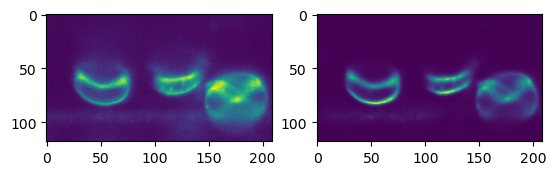

In [12]:
import matplotlib.pyplot as plt 

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.squeeze(img.data)[40,...])
axarr[1].imshow(img_norm[40,...])


## Trying RL Decon option on a larger dataset. 

This can be downloaded from: https://cloudstor.aarnet.edu.au/plus/s/JerHyB7hAIOXiZw

In [3]:
#Can also optionally generate a numpy array of shape (834,300,2048) for testing purposes
img_large = AICSImage("C:\\Users\\deepu\\Documents\\RBC_full_time_series.czi")

img_large.dask_data

dask.array<transpose, shape=(3, 1, 834, 300, 2048), dtype=uint16, chunksize=(1, 1, 834, 300, 2048), chunktype=numpy.ndarray>

In [4]:
img_large_data = img_large.data[0,0,...]
print(img_large_data.shape)

(834, 300, 2048)


In [5]:
def pad_image_nearest_multiple(img:np.ndarray,nearest_multiple:int,is_psf=False):
    """pad an Image to the nearest multiple of provided number

    Args:
        img (np.ndarray): 
        nearest_multiple (int): Multiple of number to be padded

    Returns:
        np.ndarray: Padded image
    """    
    import math
    if is_psf:
        rounded_shape = (math.ceil(img.shape[0]/2)*2,
                         math.ceil(img.shape[1]/nearest_multiple)*nearest_multiple,
                         math.ceil(img.shape[2]/nearest_multiple)*nearest_multiple)
    else:
        rounded_shape = tuple([math.ceil(dim/nearest_multiple)*nearest_multiple for dim in img.shape])
    #get required padding
    
        
    padding = np.array(rounded_shape) - np.array(img.shape)
    padded_img = np.pad(img,((0,padding[0]),(0,padding[1]),(0,padding[2])),mode="reflect")
    return padded_img


#pad PSF by with multiple of 256
psf_pad = pad_image_nearest_multiple(psf_1,256,True)
img_pad = pad_image_nearest_multiple(img_large_data,256)

print(f"Padded image shape is {img_pad.shape}")
print(f"Padded PSF shape is {psf_pad.shape}")	

Padded image shape is (1024, 512, 2048)
Padded PSF shape is (94, 256, 256)


Taking more than 2 hours, so had to stop the code below

In [6]:
%%timeit -r 1 -n 1
img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")

28-Sep-22 00:20:17 - root     - ERROR    - Shape (1024, 512, 2048) is too large for OpenCL device shape limits [1024, 1024, 64]
28-Sep-22 00:20:23 - root     - ERROR    - blockshape is too large. Exiting.


1min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
img_decon_large= rl.doRLDeconvolutionFromNpArrays(data_np = img_pad, 
                                                    psf_np = psf_pad, 
                                                    niter= 10, 
                                                    method = "gpu")
print(img_decon_large.shape)
print(img_large_data.shape)

28-Sep-22 00:22:46 - root     - ERROR    - Shape (1024, 512, 2048) is too large for OpenCL device shape limits [1024, 1024, 64]
28-Sep-22 00:22:50 - root     - ERROR    - blockshape is too large. Exiting.


(1024, 512, 2048)
(834, 300, 2048)


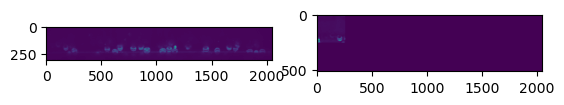

In [9]:
import matplotlib.pyplot as plt 
fig,axes = plt.subplots(1,2)

axes[0].imshow(img_large_data[40,...])
axes[1].imshow(img_decon_large[40,...])

#plt.imshow(img_decon_large[40,...])

In [8]:
import napari 

viewer = napari.Viewer()
viewer.add_image(img_large_data, name = "raw")
viewer.add_image(img_decon_large, name = "decon")

c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'decon' at 0x20ab3a87130>

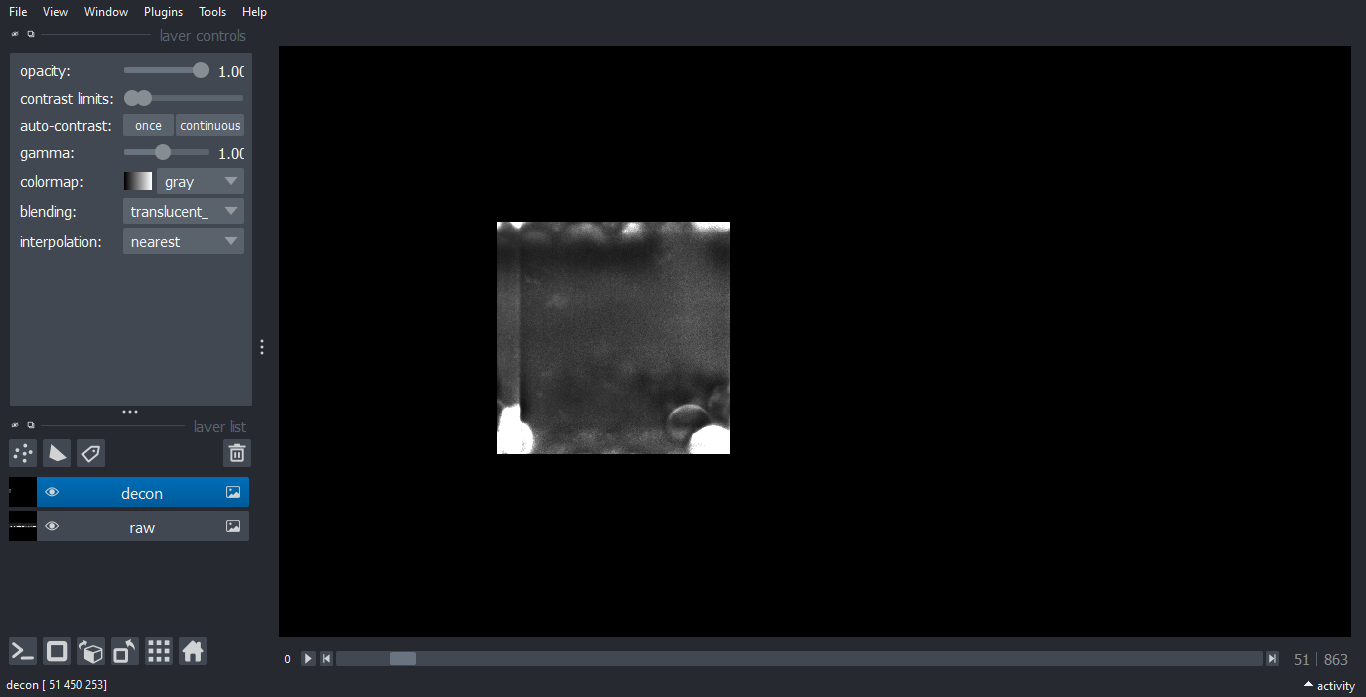

In [27]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

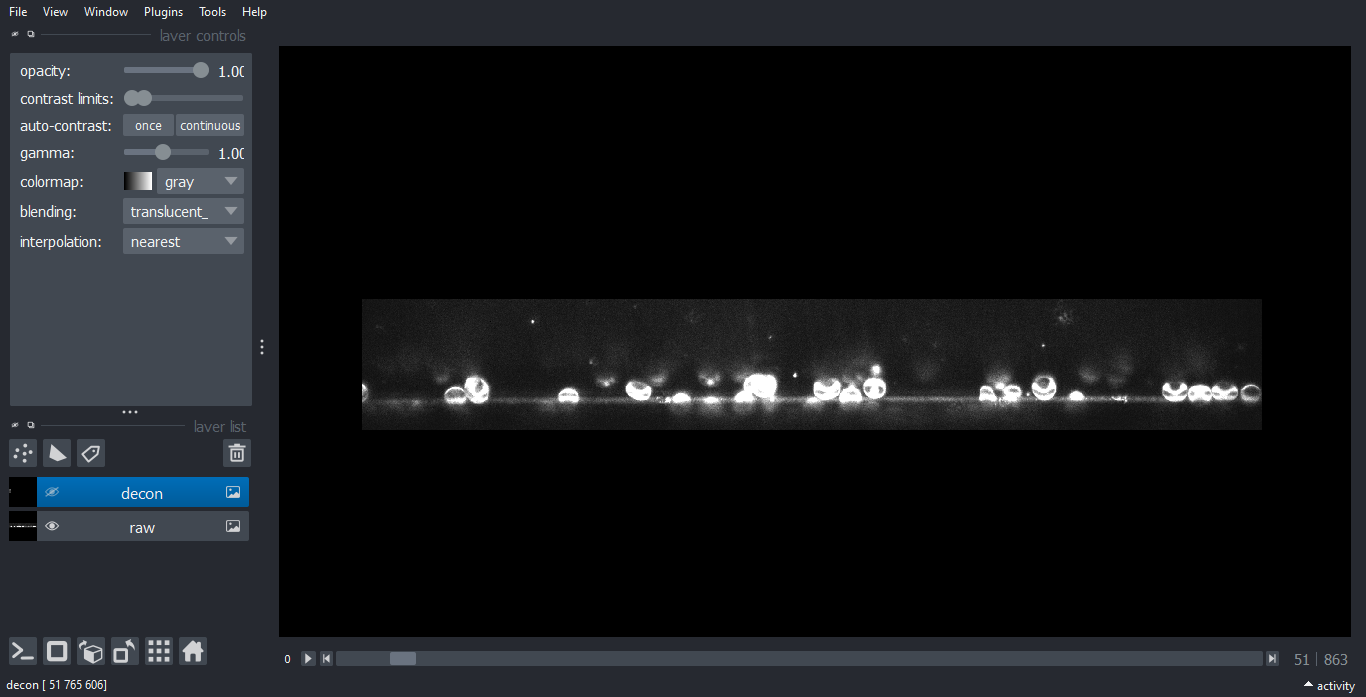

In [28]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

In [1]:
import reikna.cluda as cluda
api = cluda.ocl_api()
#code from test_reiknaFFT\reikna_getInfo.ipynb
devices = api.get_platforms()[0].get_devices()
print(f"OpenCL devices: {devices}")
for i in range(len(devices)):
    ocldevice = devices[i]
    print(f"Device {i}: {ocldevice}")
    print(f"max_work_group_size: {api.DeviceParameters(ocldevice).max_work_group_size}") # max_work_group_size: 1024
    print(f"max_work_item_sizes: {api.DeviceParameters(ocldevice).max_work_item_sizes}") # max_work_item_sizes: [1024, 1024, 64]
    print(f"max_num_groups: {api.DeviceParameters(ocldevice).max_num_groups}") # max_num_groups: [18446744073709551616, 18446744073709551616, 18446744073709551616]
    print(f"local_mem_size: {api.DeviceParameters(ocldevice).local_mem_size}") # local_mem_size: 49152
    print(f"local_mem_banks: {api.DeviceParameters(ocldevice).local_mem_banks}") # local_mem_banks: 32

OpenCL devices: [<pyopencl.Device 'NVIDIA GeForce MX150' on 'NVIDIA CUDA' at 0x20141e77580>]
Device 0: <pyopencl.Device 'NVIDIA GeForce MX150' on 'NVIDIA CUDA' at 0x20141e77580>
max_work_group_size: 1024
max_work_item_sizes: [1024, 1024, 64]
max_num_groups: [18446744073709551616, 18446744073709551616, 18446744073709551616]
local_mem_size: 49152
local_mem_banks: 32
